In [8]:
#@title Titre par défaut
import argparse
import os
import numpy as np
import math
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1000, help="number of epochs of training") #200
parser.add_argument("--batch_size", type=int, default=8, help="size of the batches") #64
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=32, help="dimensionality of the latent space") #100
parser.add_argument("--img_size", type=int, default=64, help="size of each image dimension") # NMC 32-64-128 /
parser.add_argument("--channels", type=int, default=1, help="number of image channels") #1
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image samples")
opt = parser.parse_args('')
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

normalization_choice=3
# 0 -> Nothing
# 1 -> only spectral normalization on discriminator
# 2 -> only batch_norm on generator
# 3 -> only instance normalization on generator 
# 4 -> both spectral and batch
# 5 -> both spectral and instance


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat,normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]

            if normalization_choice>1 and normalize: 
                if normalization_choice%2==0:
                  layers.append(nn.BatchNorm1d(out_feat, 0.8))  
                else:
                  layers.append(nn.InstanceNorm1d(out_feat, 0.8)) #out_feat size -> 64 
                #layers.append(spectral_norm(nn.BatchNorm1d(out_feat, 0.8))) useless?
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        if (normalization_choice==1 or normalization_choice>3):
          self.model = nn.Sequential(
              nn.Linear(int(np.prod(img_shape)), 512), 
              nn.LeakyReLU(0.2, inplace=True),
              nn.Linear(512, 256), 
              nn.LeakyReLU(0.2, inplace=True),
              nn.Linear(256, 1), 
              nn.Sigmoid(),
          )
        else:
          self.model = nn.Sequential(
              nn.utils.spectral_norm(nn.Linear(int(np.prod(img_shape)), 512)),
              nn.LeakyReLU(0.2, inplace=True),
              nn.utils.spectral_norm(nn.Linear(512, 256)),
              nn.LeakyReLU(0.2, inplace=True),
              nn.utils.spectral_norm(nn.Linear(256, 1)),
              nn.Sigmoid(),
          )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity



# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()




Namespace(n_epochs=1000, batch_size=8, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=32, img_size=64, channels=1, sample_interval=400)


In [11]:
## Load trained models
# After loading some pre-trained models, skip the next parts until the plots and generation parts at the end (else you will re-train the model)

Use_of_loaded_model=1

#Be careful if you request a models that has never been saved of course you will get an error
n_epochs_requested=1000
batch_size_requested=8
img_size_requested=64 #32-64-128
normalization_choice=3 # 0-1-2-3-4-5
img_type="NMC"
latent_dim=32 # most of the time img_size/2

#path
pathd = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/netD_epoch_{n_epochs_requested}_BatchSize_{batch_size_requested}_{img_type}_{img_size_requested}_normalization_choice_{normalization_choice}_LatentSize_{latent_dim}.pt" 
pathg = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/netG_epoch_{n_epochs_requested}_BatchSize_{batch_size_requested}_{img_type}_{img_size_requested}_normalization_choice_{normalization_choice}_LatentSize_{latent_dim}.pt" 

pathD = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/D_losses_epoch_{n_epochs_requested}_BatchSize_{batch_size_requested}_{img_type}_{img_size_requested}_normalization_choice_{normalization_choice}_LatentSize_{latent_dim}.pt" 
pathG = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/G_losses_epoch_{n_epochs_requested}_BatchSize_{batch_size_requested}_{img_type}_{img_size_requested}_normalization_choice_{normalization_choice}_LatentSize_{latent_dim}.pt" 

#Discriminator
discriminator = Discriminator()
discriminator.load_state_dict(torch.load(pathd,map_location=torch.device('cpu')))
discriminator.eval()

#Generator
generator = Generator()
generator.load_state_dict(torch.load(pathg,map_location=torch.device('cpu')))
generator.eval()

#Lists for plot
temporary_tensorD = torch.load(pathD)
temporary_tensorG = torch.load(pathG)
D_losses = temporary_tensorD.tolist() #convert tensor to list
G_losses = temporary_tensorG.tolist()



In [2]:
## Configure and load of the data loader

# Path
img_type="NMC"
from google.colab import drive
drive.mount('/content/drive')
PATH = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Data/{img_type}-{opt.img_size}" #32 64 128 ...

# Transformation applied
transform = transforms.Compose([
    transforms.Resize((opt.img_size,opt.img_size)),  # resize images at opt.img_size
    transforms.Grayscale(),  # Grayscale
    transforms.ToTensor(),  # images -> tensor
    transforms.Normalize([0.5], [0.5])  # normalise tensors 
])

# Download of images
dataset = datasets.ImageFolder(root=PATH, transform=transform)

# Making of the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)


Mounted at /content/drive


In [9]:
## Optimizers / Training of the models

Use_of_loaded_model=0

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


# ----------
#  Training
# ----------

D_losses = []
G_losses = []
iterations = []

time_start=time.time()

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        if (epoch%50 ==0)and(i==0)and(epoch>0): #speed evaluation
          time_spent=round(time.time()-time_start)
          average_speed=round(epoch/time_spent,2)
          estimated_time=round((opt.n_epochs-epoch)/average_speed)
          time_formate = time.strftime("%Hh %Mmin %Ss", time.gmtime(time_spent))
          estimated_formate= time.strftime("%Hh %Mmin %Ss", time.gmtime(estimated_time))
          print(f"\033[91m Epoch: {epoch}/{opt.n_epochs}, time spent: {time_formate}, average speed until now: {average_speed} epoch/s and estimated time remaining : {estimated_formate}.\033[0m")

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 200 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
          )
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        iterations.append(i)

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

time_spent=round(time.time()-time_start)
average_speed=round(epoch/time_spent,3)
time_formate = time.strftime("%Hh %Mmin %Ss", time.gmtime(time_spent))
print(f"\033[91m Training done, time spent: {time_formate}, average speed : {average_speed} epoch/s.\033[0m")


[Epoch 0/1000] [Batch 0/24] [D loss: 0.691551] [G loss: 0.670573]
[Epoch 1/1000] [Batch 0/24] [D loss: 0.400411] [G loss: 0.755462]
[Epoch 2/1000] [Batch 0/24] [D loss: 0.284010] [G loss: 0.990487]
[Epoch 3/1000] [Batch 0/24] [D loss: 0.553876] [G loss: 0.745457]
[Epoch 4/1000] [Batch 0/24] [D loss: 0.509489] [G loss: 0.931507]
[Epoch 5/1000] [Batch 0/24] [D loss: 0.730021] [G loss: 0.938480]
[Epoch 6/1000] [Batch 0/24] [D loss: 0.644820] [G loss: 0.769160]
[Epoch 7/1000] [Batch 0/24] [D loss: 0.578036] [G loss: 0.815748]
[Epoch 8/1000] [Batch 0/24] [D loss: 0.547900] [G loss: 0.737286]
[Epoch 9/1000] [Batch 0/24] [D loss: 0.626588] [G loss: 0.794080]
[Epoch 10/1000] [Batch 0/24] [D loss: 0.653498] [G loss: 0.736892]
[Epoch 11/1000] [Batch 0/24] [D loss: 0.582425] [G loss: 0.806886]
[Epoch 12/1000] [Batch 0/24] [D loss: 0.598018] [G loss: 0.741269]
[Epoch 13/1000] [Batch 0/24] [D loss: 0.509923] [G loss: 0.812246]
[Epoch 14/1000] [Batch 0/24] [D loss: 0.573207] [G loss: 0.776370]
[Epoc

In [10]:
## Saved trained models
Use_of_loaded_model=0
if Use_of_loaded_model==0:
  #path
  pathd = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/netD_epoch_{opt.n_epochs}_BatchSize_{opt.batch_size}_{img_type}_{opt.img_size}_normalization_choice_{normalization_choice}_LatentSize_{opt.latent_dim}.pt" 
  pathg = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/netG_epoch_{opt.n_epochs}_BatchSize_{opt.batch_size}_{img_type}_{opt.img_size}_normalization_choice_{normalization_choice}_LatentSize_{opt.latent_dim}.pt" 
  #save models
  torch.save(generator.state_dict(), pathg) 
  torch.save(discriminator.state_dict(), pathd)

  # convert the lists in tensor object
  tensor_D_losses = torch.tensor(D_losses)
  tensor_G_losses = torch.tensor(G_losses)
  #path
  pathD = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/D_losses_epoch_{opt.n_epochs}_BatchSize_{opt.batch_size}_{img_type}_{opt.img_size}_normalization_choice_{normalization_choice}_LatentSize_{opt.latent_dim}.pt" 
  pathG = f"/content/drive/MyDrive/Colab_Notebooks/MAT7/Saved_models/G_losses_epoch_{opt.n_epochs}_BatchSize_{opt.batch_size}_{img_type}_{opt.img_size}_normalization_choice_{normalization_choice}_LatentSize_{opt.latent_dim}.pt" 
  # save lists for plot
  torch.save(tensor_D_losses, pathD)
  torch.save(tensor_G_losses, pathG)

else:
  print("Wait you are trying to save the model you just loaded")


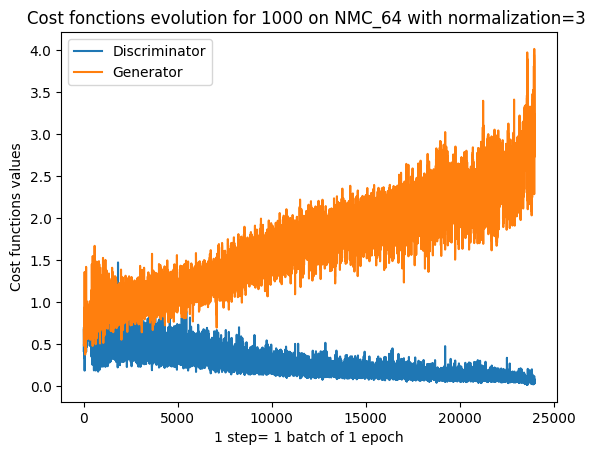

In [13]:
## PLOT
import matplotlib.pyplot as plt
# Plot of the loss functions of both the Generator and the Discriminator on the same graph
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
if Use_of_loaded_model==0:
  plt.title(f'Cost fonctions evolution for {opt.n_epochs} on {img_type}_{opt.img_size} with normalization={normalization_choice} ')
else:
  plt.title(f'Cost fonctions evolution for {n_epochs_requested} on {img_type}_{img_size_requested} with normalization={normalization_choice} ')
plt.xlabel('1 step= 1 batch of 1 epoch')
plt.ylabel('Cost functions values')
plt.legend()
plt.show()

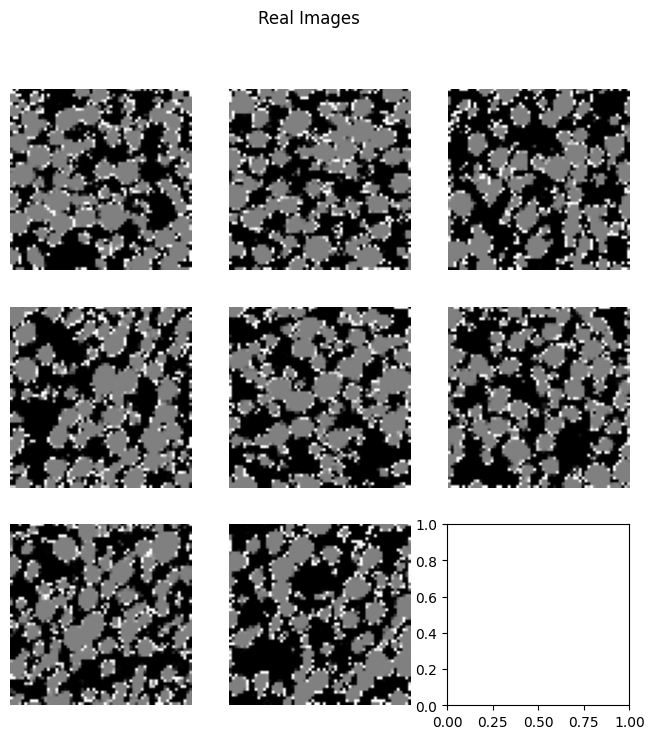

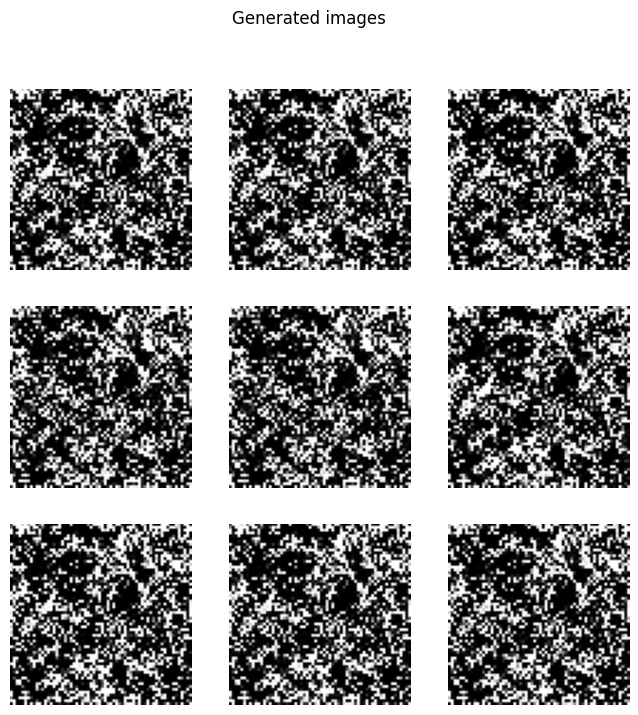

In [12]:
# Display of real and generated images once our generator has been trained.

Gray=1 # 1 for gray, 0 for RGB

# Real images
batch = next(iter(dataloader))  # Getting First batch
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
plt.suptitle('Real Images')

for i, ax in enumerate(axes.flat):
    if i < min(9, opt.batch_size):  # 'opt.batch_size :
        img = batch[0][i]
        if Gray:
            img_gray = torch.mean(img, dim=0, keepdim=True)
            ax.imshow(img_gray.squeeze(), cmap='gray')
        else:
            imv = img.permute(1, 2, 0)[:, :, 0]
            for ii in range(opt.img_size):
                for jj in range(opt.img_size):
                    v = imv[ii, jj]
                    if v > 0:
                        v = - v
                    v = 2 * v + 1
                    imv[ii, jj] = v+1
            ax.imshow(imv, cmap='gray')
        ax.axis('off')

plt.show()

# Generated images
#z = torch.randn(imgs.shape[0], opt.latent_dim)
z = torch.randn(16, opt.latent_dim)
gen_imgs = generator(z)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8)) #4 4 8 8
for i, ax in enumerate(axes.flat):
    if i<9:
      if Gray:
        img = gen_imgs[i].permute(1, 2, 0).detach() 
        img_gray = torch.mean(img, dim=2, keepdim=True) 
        ax.imshow(img_gray.squeeze(), cmap='gray') 
      else:
        img = gen_imgs[i].permute(1, 2, 0).detach().numpy()  # Permuter les dimensions de l'image et détacher le tenseur
        ax.imshow(img) 
      ax.axis('off')

plt.suptitle('Generated images')
plt.show()
